<a href="https://colab.research.google.com/github/NikkiShah93/Python/blob/main/MLProjects/PyTorchProjects/DeepLearning/cnn_pytorch_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN in PyTorch

We have two classification model in this notebook. Using the following datasets from `torchvision`.

- MNIST [Documentation](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)
  - [Loading and expolarations](#mnloadex)
  - [Starting with our CNN model](#mncnnmodel)


- FashionMNIST [Documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)
  - [Loading and expolarations](#mnfloadex)
  - [Starting with our CNN model](#mnfcnnmodel)

In [1]:
## first the imports
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [2]:
## setting the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
## setting the roots
ROOT = '/data'
PATH = Path(ROOT)
PATH.mkdir(parents=True, exist_ok=True)

<a name = 'mnloadex'> </a>
Loading and Exploration

In [4]:
## getting some toy data from torchvision
BATCH_SIZE = 128
MNIST_train = datasets.MNIST(root=ROOT,
                                train=True,
                                download=True,
                                transform=transforms.ToTensor())
MNIST_test = datasets.MNIST(root=ROOT,
                                train=False,
                                transform=transforms.ToTensor())
print('The training data classes are: ', ', '.join(MNIST_train.classes))
N_CLASSES = len(MNIST_train.classes)
## next we want to load the data
MNIST_train_loader = torch.utils.data.DataLoader(dataset=MNIST_train,
                              batch_size=BATCH_SIZE,
                             shuffle=True)

MNIST_test_loader = torch.utils.data.DataLoader(dataset=MNIST_test,
                              batch_size=BATCH_SIZE,
                             shuffle=True)

## checking out our first bacth
example_iter = iter(MNIST_train_loader)
next_obj = next(example_iter)
n_channels = next_obj[0].shape[1]
n_inputs = next_obj[0].shape[-1]
print(next_obj[0].shape, type(next_obj[0]))
print(len(MNIST_train_loader))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18380733.18it/s]


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 498607.50it/s]


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4471977.86it/s]


Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5533119.01it/s]


Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw

The training data classes are:  0 - zero, 1 - one, 2 - two, 3 - three, 4 - four, 5 - five, 6 - six, 7 - seven, 8 - eight, 9 - nine
torch.Size([128, 1, 28, 28]) <class 'torch.Tensor'>
469


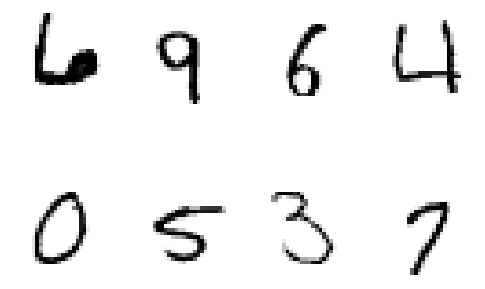

In [5]:
## plotting some images
fig, ax = plt.subplots(nrows = 2, ncols=4,
                       figsize = (6, 4))
c = 0
for i in range(2):
  for j in range(4):
    ax[i, j].imshow(torch.permute_copy(next_obj[0][c],
                                       dims = [1, 2, 0]), ## moving the color to the end we could also use squeeze for greyscalse
                    cmap='Greys')
    c +=1
    ax[i, j].set_axis_off()

<a name = mncnnmodel> </a>
Starting with our CNN model

In [6]:
## next the actual model
class ClassificationModel(nn.Module):
  def __init__(self, n_in, n_out, hidden, n_ch):
    super().__init__()

    self.conv1= nn.Conv2d(in_channels= n_ch,
                  out_channels=n_in,
                  kernel_size=3)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(in_channels=n_in,
                  out_channels=hidden,
                  kernel_size=3)
    self.l1 = nn.Linear(in_features = hidden*5*5,
                  out_features=hidden)
    self.l2 = nn.Linear(in_features=hidden,
                  out_features=n_out)

  def forward(self, x):
    out = self.pool(self.relu(self.conv1(x)))
    out = self.pool(self.relu(self.conv2(out)))
    out = torch.flatten(out, 1)
    out = self.relu(self.l1(out))
    return self.l2(out)

## creating an instance
model = ClassificationModel(n_ch=n_channels,
                            n_in=n_inputs,
                            n_out=N_CLASSES,
                            hidden=8**2).to(device)
learning_rate = 1e-3
## starting with loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=learning_rate)
## next is the training loop
epochs = 4
avg_loss = 0.0
start = timer()
for e in tqdm(range(epochs)):
  for image, labels in MNIST_train_loader:
    image, labels = image.to(device), labels.to(device)
    pred_labels = model(image)
    l = loss_fn(pred_labels, labels)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    avg_loss += l.item()
  print(f'Epoch: {e} - Average Loss:{avg_loss/len(MNIST_train_loader):.4f}')
  avg_loss = 0.0

end = timer()
print(f'Time taken: {(end - start):.3} seconds')

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0 - Average Loss:0.2723
Epoch: 1 - Average Loss:0.0721
Epoch: 2 - Average Loss:0.0507
Epoch: 3 - Average Loss:0.0406
Time taken: 34.7 seconds


In [7]:
## starting with the test loop
model.eval()
avg_test_loss = 0
with torch.inference_mode():
  for test_image, test_label in MNIST_test_loader:
    test_image, test_label = test_image.to(device), test_label.to(device)
    test_preds = model(test_image)
    test_loss = loss_fn(test_preds, test_label)
    avg_test_loss += test_loss.item()
  print(f'The average test loss is: {avg_test_loss/len(MNIST_test_loader):.4f}')

The average test loss is: 0.0389


## FashionMNIST Example

<a name = 'mnfloadex'> </a>
Loading and Explorations

In [8]:
BATCH_SIZE = 128
fashin_train = datasets.FashionMNIST(root=ROOT,
                                     train=True,
                                     download=True,
                                     transform=transforms.ToTensor())
fashin_test = datasets.FashionMNIST(root=ROOT,
                                    train=False,
                                     transform=transforms.ToTensor())
print('The training data classes are:', ', '.join(fashin_train.classes))
classes = fashin_train.classes
N_CLASSES = len(classes)
train_loader = torch.utils.data.DataLoader(fashin_train,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(fashin_test,
                                           batch_size = BATCH_SIZE,
                                          shuffle=True)
## checking out our data
example_iter = iter(train_loader)
example_image, example_label = next(example_iter)
IN_CHANNELS = example_image.shape[1]
N_INPUTS = example_image.shape[2]
print(example_image.shape, type(example_image), example_label.shape)

100%|██████████| 26421880/26421880 [00:02<00:00, 11944922.66it/s]


Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202313.93it/s]


Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3732606.73it/s]


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5754871.27it/s]

Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw

The training data classes are: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
torch.Size([128, 1, 28, 28]) <class 'torch.Tensor'> torch.Size([128])


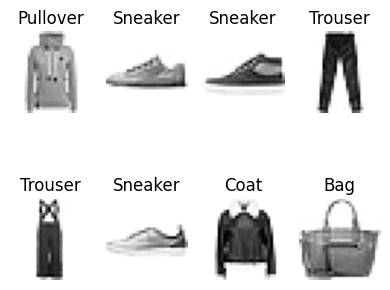

In [9]:
## plot some examples
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (4, 4))
c = 0
for i in range(2):
  for j in range(4):
    ax[i, j].imshow(torch.permute(example_image[c], [1,2,0])
    , cmap='Greys')
    ax[i, j].set_title(classes[example_label[c].item()])
    c+=1
    ax[i, j].set_axis_off()
fig.tight_layout();

<a name = mnfcnnmodel> </a>
Starting with our CNN model

In [10]:
## starting with the model
class Classifier(nn.Module):
  def __init__(self, n_channels, n_inputs, n_hidden, n_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(n_channels, n_inputs, 5)
    self.conv2 = nn.Conv2d(n_inputs, n_hidden, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.l1 = nn.Linear(in_features= n_hidden*4*4,
                        out_features=n_hidden)
    self.l2 = nn.Linear(in_features=n_hidden,
                        out_features=n_classes)
  def forward(self, x:torch.tensor) -> torch.tensor:
    out = self.pool(self.relu(self.conv1(x)))
    out = self.pool(self.relu(self.conv2(out)))
    out = torch.flatten(out, 1)
    out = self.l1(out)
    return self.l2(out)

learning_rate = 1e-3
model_2 = Classifier(n_channels=IN_CHANNELS,
                     n_inputs=N_INPUTS,
                     n_hidden=8**2,
                     n_classes=N_CLASSES).to(device)
## starting with the loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(),
                             lr=learning_rate)

## starting with the training loop
epochs = 5
avg_loss = 0.0
start = timer()
for e in tqdm(range(epochs)):
  for image, labels in train_loader:
    image, labels = image.to(device), labels.to(device)
    pred_labels = model_2(image)
    loss = loss_fn(pred_labels, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
  print(f'Epoch: {e} - Average Loss:{avg_loss/len(train_loader):.4f}')
  avg_loss = 0.0
end = timer()
print(f'Time taken: {(end - start):.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 - Average Loss:0.5789
Epoch: 1 - Average Loss:0.3691
Epoch: 2 - Average Loss:0.3182
Epoch: 3 - Average Loss:0.2880
Epoch: 4 - Average Loss:0.2647
Time taken: 44.009


In [11]:
## the testing loop
model_2.eval()
avg_test_loss = 0
with torch.inference_mode():
  for test_image, test_label in test_loader:
    test_image, test_label = test_image.to(device), test_label.to(device)
    test_pred = model_2(test_image)
    test_loss = loss_fn(test_pred, test_label)
    avg_test_loss += test_loss.item()
  print(f'The average test loss: {avg_test_loss/len(test_loader):.4}')

The average test loss: 0.2846
